# Life-Cycle Labor Supply

Solves and simulates a $T$-period labor supply model with consumption-saving in Keane(2016).

The **Bellman equation** and the recursive formulation of the model is 

$$
\begin{align}
V_{t}(a_{t},k_{t})=&\max_{c_{t},h_{t}}\frac{c_{t}^{1+\eta}}{1+\eta}-\beta\frac{h_{t}^{1+\gamma}}{1+\gamma}+\rho V_{t+1}(a_{t+1},k_{t+1}) \\
& \text{s.t.} \\
a_{t+1}=&(1+r)(a_{t}+(1-\tau)w_{t}h_{t}-c_{t}) \\
k_{t+1} =&k_{t}+h_{t}
\end{align}
$$
such that wages are endogenous
$$
\begin{align}
w_{t}&=w\left(1+\alpha k_{t}\right)\\
&=w\left(1+\alpha\sum_{s=1}^{t-1}h_{s}\right).
\end{align}
$$

We will solve this by **backwards induction**, assuming no bequest motive. The last-period problem becomes
$$
\begin{align}
V_{T}(a_T,k_T)=&\max_{h_{T}}\frac{c_{T}^{1+\eta}}{1+\eta}-\beta\frac{h_{T}^{1+\gamma}}{1+\gamma} \\
& \text{s.t.} \\
c_T = &a_{T}+(1-\tau)w_{T}h_{T}.
\end{align}
$$

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# Consumption-Saving Model

In [2]:
# load local model file and initialize model class
from DynLaborModel_12 import DynLaborModelClass
model = DynLaborModelClass(par={'T':4,'r':0.02,'rho':1/(1.02),'alpha':0.1}) # set a few number of periods.

par = model.par
sol = model.sol
sim = model.sim

**Grids:** $\overrightarrow{a}$ and $\overrightarrow{k}$

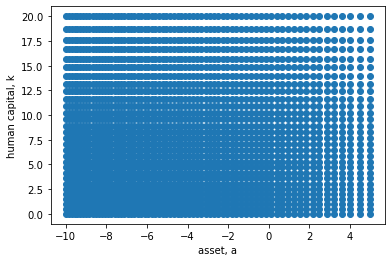

In [4]:
fig, ax = plt.subplots()
a_mesh,k_mesh = np.meshgrid(par.a_grid,par.k_grid,indexing='ij')
ax.scatter(a_mesh,k_mesh)
ax.set(xlabel='asset, a',ylabel='human capital, k');

## Solve the model

In [5]:
%time model.solve()

Wall time: 43.7 s


## Introduce a severe health shock risk
With probability $p=0.2$ all human capital is destroyed in the following period.
To implement this we change eq. (4) above:
\begin{equation}
k_{t+1} = \begin{cases}
            0 & \text{w. prob } p \\
            k_t+h_t & \text{w. prob } 1-p \\
            \end{cases}
\end{equation}

How to solve this model? The continuation value is now changed and we have 
\begin{align}
V_{t}(a_{t},k_{t})=&\max_{c_{t},h_{t}}\frac{c_{t}^{1+\eta}}{1+\eta}-\beta\frac{h_{t}^{1+\gamma}}{1+\gamma}+\rho \mathbb{E}_t[V_{t+1}(a_{t+1},k_{t+1})] \\
& \text{s.t.} \\
a_{t+1}=&(1+r)(a_{t}+(1-\tau)w_{t}h_{t}-c_{t}) \\
k_{t+1} =& \begin{cases}
            0 & \text{w. prob } p \\
            k_t+h_t & \text{w. prob } 1-p \\
            \end{cases}
\end{align}

where 
\begin{equation}
\mathbb{E}_t[V_{t+1}(a_{t+1},k_{t+1})] = p \cdot V_{t+1}(a_{t+1},0) + (1-p)\cdot V_{t+1}(a_{t+1},k_{t+1})
\end{equation}

In [11]:
# try solving this new model
model = DynLaborModelClass(par={'T':4,'r':0.02,'rho':1/(1.02),'alpha':0.1}) # set a few number of periods.
%time model.solve()

Wall time: 1min 20s


## How to simulate??
We will introduce randomness in the simulation such that with probability $p$ human capital transitions to 0. 

Note that if $U\sim Uniform(0,1)$ then $P(u\leq p)=p$. We will use this and draw uniform random variable on the unit interval and store it in `sim.draws_uni` and then check in the simulation module if this is less than $p$. If so, we will let $k_{i,t+1}=0$.

In [12]:
# Simulate
model.simulate()

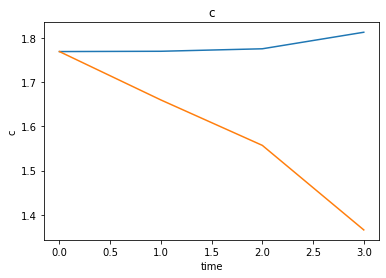

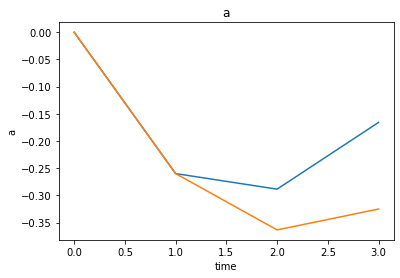

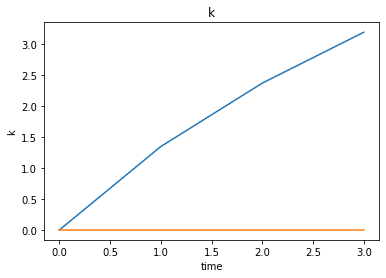

In [15]:
# plot simulated outcomes
for var in ('c','a','k'):
    fig, ax = plt.subplots()
    ax.plot( np.mean(getattr(model.sim,var) , axis = 0) )
    ax.plot( np.min(getattr(model.sim,var) , axis = 0) )
    ax.set(title=var,xlabel='time',ylabel=var)

In [16]:
# want to compare outcomes from the old and new model
model_old = model.copy()
model_old.par.p = 0.0

model_old.solve()
model_old.simulate()

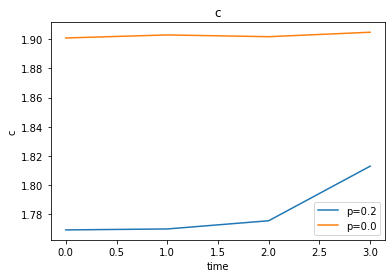

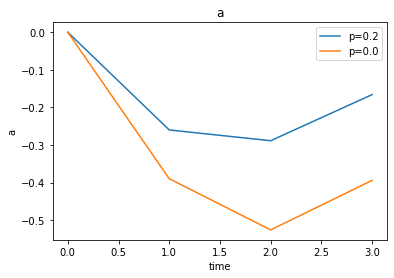

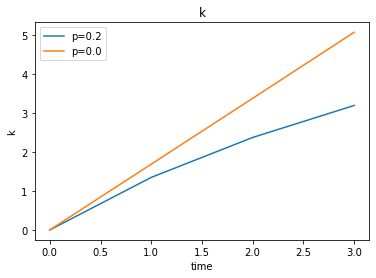

In [17]:
# plot simulated outcomes
for var in ('c','a','k'):
    fig, ax = plt.subplots()
    ax.plot( np.mean(getattr(model.sim,var) , axis = 0) ,label='p=0.2')
    ax.plot( np.mean(getattr(model_old.sim,var) , axis = 0) ,label ='p=0.0')
    ax.set(title=var,xlabel='time',ylabel=var)
    ax.legend();

## Add a state variable that is fixed throughout life
We could have different types with different preferences for leisure. 
Type 1 has $\beta = 0.1$ while Type 2 has $\beta=0.2$. 

We will introduce a new state, $m \in \{1,2\}$.
The recursive formulation becomes
\begin{align}
V_{t}(m,a_{t},k_{t})=&\max_{c_{t},h_{t}}\frac{c_{t}^{1+\eta}}{1+\eta}-\beta(m)\frac{h_{t}^{1+\gamma}}{1+\gamma}+\rho \mathbb{E}_t[V_{t+1}(m,a_{t+1},k_{t+1})] \\
& \text{s.t.} \\
a_{t+1}=&(1+r)(a_{t}+(1-\tau)w_{t}h_{t}-c_{t}) \\
k_{t+1} =& \begin{cases}
            0 & \text{w. prob } p \\
            k_t+h_t & \text{w. prob } 1-p \\
            \end{cases}
\end{align}

where 
\begin{equation}
\mathbb{E}_t[V_{t+1}(m,a_{t+1},k_{t+1})] = p \cdot V_{t+1}(m,a_{t+1},0) + (1-p)\cdot V_{t+1}(m,a_{t+1},k_{t+1})
\end{equation}
and
\begin{equation}
\beta(m) = \beta_1\mathbf{1}(m=1)+\beta_2\mathbf{1}(m=2)
\end{equation}



In [28]:
model = DynLaborModelClass(par={'T':4,'r':0.02,'rho':1/(1.02),'alpha':0.1}) # set a few number of periods.

In [31]:
# plot all models
model_base = DynLaborModelClass(par={'T':4,'r':0.02,'rho':1/(1.02),'alpha':0.1,'p':0.0,'Nm':1}) 
model_shock = DynLaborModelClass(par={'T':4,'r':0.02,'rho':1/(1.02),'alpha':0.1,'p':0.2,'Nm':1}) 
model = DynLaborModelClass(par={'T':4,'r':0.02,'rho':1/(1.02),'alpha':0.1,'p':0.2,'Nm':2}) 

# solve and simualate all version
model.solve()
model.simulate()
model_base.solve()
model_base.simulate()
model_shock.solve()
model_shock.simulate()

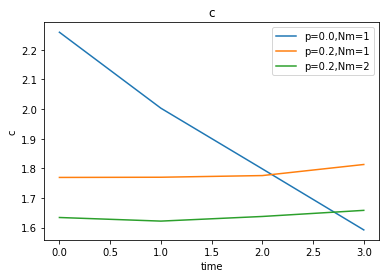

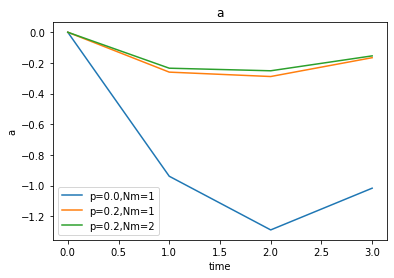

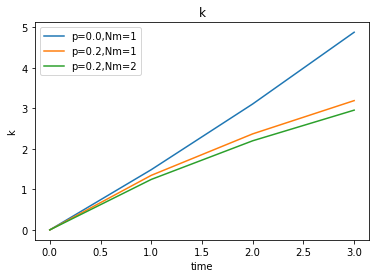

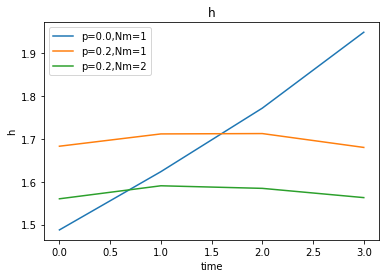

In [44]:
# plot simulated outcomes
for var in ('c','a','k','h'):
    fig, ax = plt.subplots()
    ax.plot( np.mean(getattr(model_base.sim,var) , axis = 0) ,label='p=0.0,Nm=1')
    ax.plot( np.mean(getattr(model_shock.sim,var) , axis = 0) ,label ='p=0.2,Nm=1')
    ax.plot( np.mean(getattr(model.sim,var) , axis = 0) ,label ='p=0.2,Nm=2')
    ax.set(title=var,xlabel='time',ylabel=var)
    ax.legend();

## Structural Estimation

Imagine that someone told us that the avg consumption in period 2 was 2.0 (in the baseline model due to time...)

We want to estimate the discount factor, $\rho$, using this information.

In [41]:
def calc_moments(data):
    " mean consumption in period 2"
    period = 2
    return np.array(np.mean(data.c[:,period-1]))

def obj_func(theta,theta_names,model,data_moments,do_print=False):
    
    # update model parameters (set rho=theta)
    for i, name in enumerate(theta_names):
        setattr(model.par,name,theta[i])

    # solve and simulate the model
    model.solve()
    model.simulate()

    # calculate moments
    model_moments = calc_moments(model.sim)

    # calculate distance between model and data moments
    distance = model_moments - data_moments

    # calculate objective function (sum of squared distances)
    obj = np.sum(distance**2)

    if do_print: print(f"theta: {theta}, obj: {obj:2.6f}")
    return obj



In [38]:
data_moments = np.array([2.0]) # data moments (mean consumption in period 2)
theta_names = ('rho',) # parameters to be estimated
theta_init = np.array([0.98]) # initial guess for parameters to be estimated

obj_func(theta_init,theta_names,model_base,data_moments)

0.009398606464012565

In [39]:
obj_func(np.array([0.97]),theta_names,model_base,data_moments)

0.008549775377430279

In [ ]:
# call numerical optimizer ( will run for approx. an hour)
from scipy.optimize import minimize

res = minimize(obj_func,theta_init,args=(theta_names,model_base,data_moments,True),method='nelder-mead',tol=0.0001)

theta: [0.98], obj: 0.009399
theta: [1.029], obj: 0.016046
theta: [0.931], obj: 0.003555
theta: [0.882], obj: 0.002177
theta: [0.784], obj: 0.000026
theta: [0.686], obj: 0.004731
theta: [0.686], obj: 0.004731
theta: [0.833], obj: 0.000955
theta: [0.735], obj: 0.001732
theta: [0.8085], obj: 0.000763
theta: [0.7595], obj: 0.000607
theta: [0.77175], obj: 0.000106
theta: [0.79625], obj: 0.000418
theta: [0.777875], obj: 0.000009


KeyboardInterrupt: 

In [ ]:
# object oriented programming: the parameters of the "model_base" will be set to the last evaluation in the objective function
model_base.par.rho # this will be 0.777875 (latest value when terminating)

0.7717500000000004